## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [89]:
# importing the package will be used n the project
import pandas as pd
from pandas.core import datetools
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from patsy import dmatrices
import seaborn as sns
# activating the seaborn 
sns.set()
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [90]:
df = pd.read_csv('ab_data.csv')
# the first 5 rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [91]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [92]:
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [93]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [94]:
df.query('(group == "control" and landing_page == "new_page") or \
    (group == "treatment" and landing_page == "old_page")').count()[0]

3893

f. Do any of the rows have missing values?

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [96]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [97]:
# making a copy of df to edit
df2 = df.copy()
# identify the indexs
error_rows = df2.query('(group == "control" and landing_page == "new_page") or \
    (group == "treatment" and landing_page == "old_page")').index
# drop the rows
df2.drop(error_rows, inplace=True)

In [98]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [99]:
df2.nunique()['user_id']

290584

In [100]:
uni_users = df2['user_id'].unique()
len(uni_users)

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [101]:
duplicated_id = df2[df2['user_id'].duplicated()]['user_id']

c. What is the row information for the repeat **user_id**? 

In [102]:
df2[df2['user_id'] == duplicated_id.iloc[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [103]:
df2.drop(duplicated_id.index , inplace=True)
df2['user_id'].count()

290584

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [104]:
# since the converted column contanis only o,1 
prob_coverted = df2['converted'].mean()
prob_coverted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [105]:
prob_control = df2.query('group == "control"')['converted'].mean()
prob_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [106]:
prob_treatment = df2.query('group == "treatment"')['converted'].mean()
prob_treatment 

0.11880806551510564

In [107]:
(prob_control - prob_treatment)*100

0.15782389853555567

d. What is the probability that an individual received the new page?

In [108]:
received_newp = (df2["landing_page"] == "new_page").mean()
received_newp

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>  the conrol group has a bit more converted than the treatment group(0.158&)
> As the chance of the individual receiving either the old or the new page has **50%** chance to be recived.
> to insure and clearify it better by making testing  (A/B Test).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} \leq p_{old} $$
$$ H_1: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [109]:
p_new = prob_coverted
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [110]:
p_old = prob_coverted
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [111]:
n_new = df2[df2['group'] == 'treatment'].user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [112]:
n_old = df2[df2['group'] == 'control'].user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [113]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17325

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [114]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17667

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [115]:
new_page_converted/n_new - old_page_converted/n_old

-0.0023837176843523877

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [116]:
p_diffs = []

for i in range(10000):  
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(p_diff)
    
np.mean(p_diffs)

-1.3044098509985477e-05

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

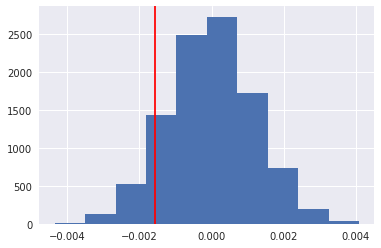

In [117]:
actual_diffs = prob_treatment - prob_control
plt.hist(p_diffs);
plt.axvline(x=actual_diffs, color='r');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [118]:
(actual_diffs < p_diffs).mean()

0.90169999999999995

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> After gettingThe probabiltiy under the null hypothesis (H0) 
>
> the significance level of this hypothesis test to α = 0.05.
> 
> So, any p_value above 0.05 (5%) would reject the null hypothesis.
>
> AS p_value = 0.9017
>
> Meaning that the old page is converted better than the new page at a very high probability, or at least equal to the new page
>
> As p_value > α
>
> So, we fail to reject the null hypothesis
> $$  p_{new} \leq p_{old} $$

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [119]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')["converted"].sum()
convert_new = df2.query('landing_page == "new_page"')["converted"].sum()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.
> and form its docs [Here](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html)

In [120]:
# calculating z-score & p-value using stats.proportions_ztest 
# with alternative value larger as it means prop > value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> As z-score = -1.31092 & p_value = 0.905.
> and z-score < p_value.
> so we failed to reject the null hypothesis.
> therefore that there is no difference between the two proportions
>
> yes they agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> AS we have only two chocie(binomial variables) We should use Logistic Regression.


b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [129]:
df2['intercept'] = 1
# i named the treatment ab_test because it has treatment value of 1 and control value of 0
df2[['control','ab_page']] =  pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [130]:
lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [131]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:08:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

> p_value of ab_test is **0.190** and it's still greater than α (0.05)
> 
> This p_value is differ here from  it's value in Part2, As the null & alternative hypotheses in two part are different. In the regression model are in two_sides lik this 
$$ H_0: p_{new} = p_{old} $$
$$ H_1: p_{new} \neq p_{old} $$


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Beacuse by adding more than one explanatory variable to our regression model,that helps us to determine the relative influence. 
This multiple logistic regression may help in making insights, that can't be happen with single logistic regression. 
>
> Yes, adding additional terms to the model has the disadvantage that instead of increasing the quality of the model it could decrease it,
> the ncomplete data may cause an incorrect relationship between our variables, 
> Also it may cause false predected correlation.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [134]:
countries_df = pd.read_csv("countries.csv")
df_new = countries_df.set_index("user_id").join(df2.set_index("user_id"),how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [143]:
df_new['country'].value_counts()
countries = df_new['country'].unique()
df_new[countries] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page,UK,US,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,1,0,1,0


In [144]:
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'CA']])
results =logit_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:               2.323e-05
Time:                        12:29:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0506      0.028      1.784      0.074      -0.005       0.106
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

> From the results above we can see that p_value of CA is 0.130, US is 0.074, and we can see p_value of CA greater than p_value of US.
> so it's clear that there's no differnt between the users lives in any country,as the converate rate for therses users will not have a large difference.
> It's not need to make different langing_page for each country.

## Resourses
 > sm.stats.proportions_ztest https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

